This notebook implements regression on the first round results with cross validation.

## Pipeline

- Data pre-processing: run codes/data_generating.py
- Reading data: read data/firstRound_4h.csv into pandas dataframe
- Cross validation: training (training, validating); testing, KFold (K = ?)
    - Emdedding
        - Onehot
        - Label 
    - Kernel
        - RBF
        - DotProduct
        - Spectrum 
            - lmer: l = ?
            - Padding_flag: add special characters before and after sequences, e.g. 'ACTGAA' -> 'ZZ' + 'ACTGAA' + 'ZZ'
            - gap_flag:add gapped features, e.g. 3-mer-1-gap
            - normalised_kernel: e.g. zero-mean, unit-norm, unit-var
        - Sum of Spectrum
            - a K_A + b K_B + c K_C, where a + b + c = 1
    - Regression model
        - Gaussian process regression 
            - alpha: scalar value add to diagonal 
            - heteroscedastic: noises are learned as well (same as normalise each replicates to have same derivatives)
- Evaluation
   - metric: e.g. Mean square error; R2
   - true label: either sample or mean of sample. 

## Splitting in terms of sequences vs samples?

For each sequence, we have at least three biological replicates. There are two ways splitting data into training and testing data: splitting in terms of sequences, where if one sequence is split into the training dataset, then all replicates of that sequences belong to the training dataset; splitting in terms of samples, where the replicates of one sequence can be in the training or testing dataset. The two methods both make sense in terms of the evaluation of Gaussian process regression.

Considering the goal is to design good sequences for the second round experiment, we expect for training, we do not have any information about the sequences in the testing dataset. That is, splitting in terms of sequences can better simulate the sequence design task. 

In this notebook, we show both two methods of splitting data. We expect that splitting in terms of samples provide a lower error in testing data since the model may have seen the sequences. The test error of splitting sequences should have higher variance, since the prediction depends on whether the sequences in test dataset similar to the sequences in the training dataset. But again, our goal is to decrease the test error as well as the variance for the case of splitting sequences. 

## Evaluate on samples vs sample mean?

For training, we use the samples as labels, since we model the label for each sequence as samples from a unknown (Gaussian) reward distribution.

For testing, we use the sample mean for the sequence (i.e. mean value of the three replicates) as label. The ideal label should be the true mean of underlying distribution (we assume is Gaussian) of a sequence, however, we do not know the true mean. The only choice is to use the sample mean to approximate the true mean, which has the risk the sample mean would deviate a lot from the true mean since the number of samples is quite low (and variance of samples is not low). 

## Choices to make within cross validation 

- alpha: scalar value add to diagonal 
- kernel
- lmer: l = ?
- For Sum_Spectrum_Kernel: b for (1 - b)/2 K_A + b K_B + (1-b)/2 K_C

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel
    
}

In [3]:
# setting

cv = 5
test_size = 0.2
random_state = 24
embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel_list = ['Spectrum_Kernel', 
               #'Sum_Spectrum_Kernel', 
               'WD_Kernel']
alpha_list = [0.1, 1, 2, 3, 5, 10]
l_lists = [[3], [6]]
b_list = [0.33, 0.6, 0.8]

weight_flag = False
padding_flag = False
gap_flag = False

## Cross Validation for sequences

In [4]:
Path = '../../data/firstRound_4h_normTrue_formatSeq.csv'

df = pd.read_csv(Path)
df.head(20)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,2.783529,NaN,3.260245,3.225496,3.089757,0.265769
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.678119,NaN,1.589655,2.374458,1.880744,0.429851
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.670263,NaN,0.091788,0.295688,0.352580,0.293404
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.948917,NaN,1.299476,1.653915,1.634102,0.325173
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,2.201733,NaN,1.786760,1.687616,1.892036,0.272748
5,5,RBS_1by1_5,bps_noncore,TGTAAGAAGGAGATATACAT,AGGAGA,NaN,0.055417,NaN,-0.188262,0.006650,-0.042065,0.128937
6,6,RBS_1by1_6,bps_noncore,TATAAGAAGGAGATATACAT,AGGAGA,NaN,1.259399,NaN,0.539809,1.048676,0.949295,0.369946
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,NaN,1.689308,NaN,1.861887,1.713073,1.754756,0.093536
8,9,RBS_1by1_9,bps_noncore,TTAAAGAAGGAGATATACAT,AGGAGA,NaN,0.521988,NaN,0.061684,0.082107,0.221926,0.260062
9,10,RBS_1by1_10,bps_noncore,TTTCAGAAGGAGATATACAT,AGGAGA,NaN,0.858082,NaN,1.263810,1.032268,1.051387,0.203539


In [5]:
#df = df[df['Group'] != 'bps'].reset_index()
df.shape

(150, 12)

Train:  0.780776597325411
Test:  -0.07217283386106232


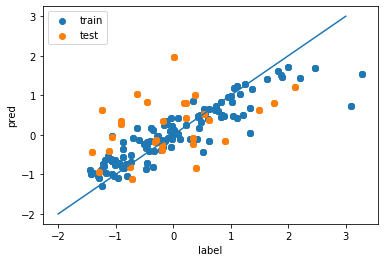

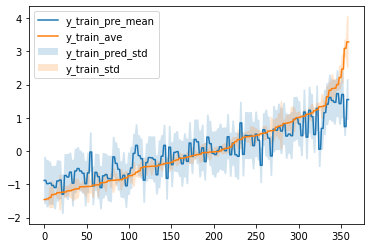

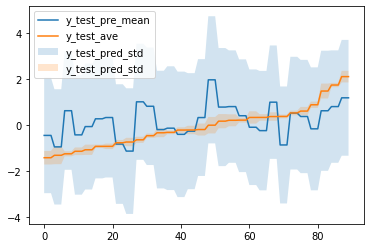

Train:  0.8082936624337624
Test:  -0.9596182898156735


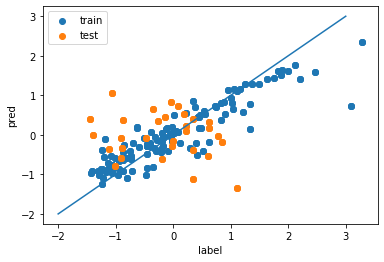

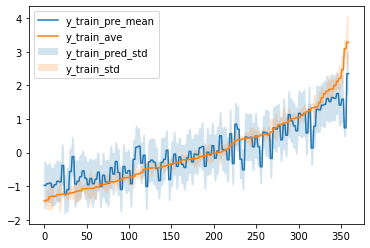

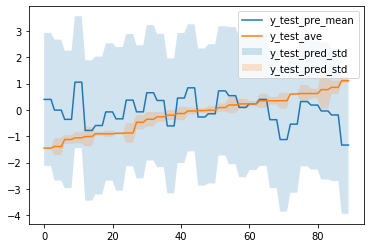

Train:  0.7657698798335957
Test:  -0.2117721448991885


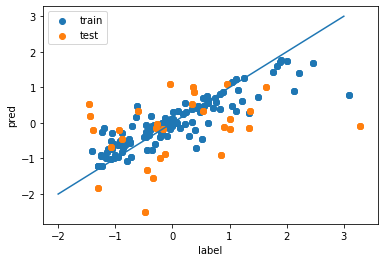

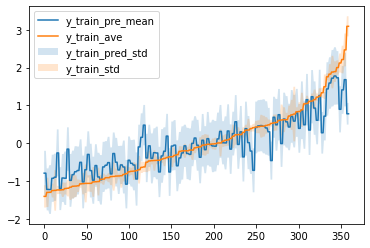

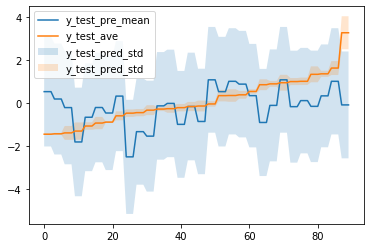

Train:  0.7587168896320742
Test:  -0.10488171657635137


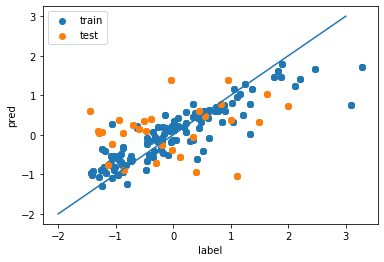

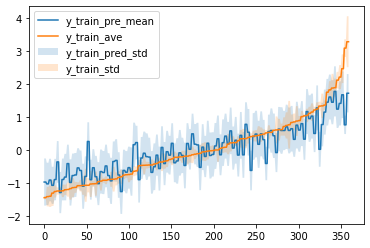

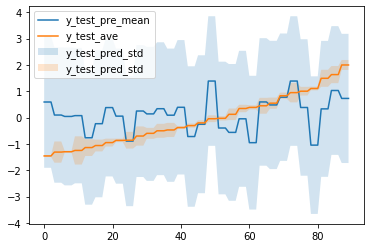

Train:  0.779637414355115
Test:  -0.1408738809102219


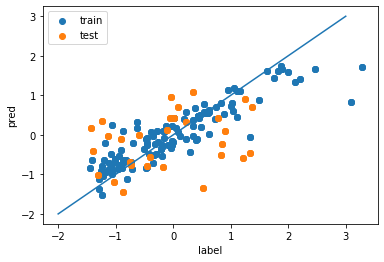

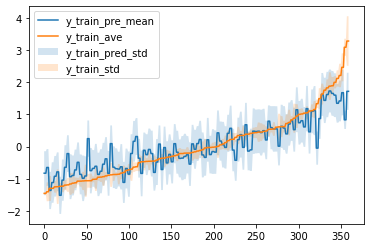

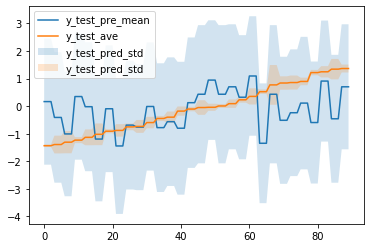

Train:  0.7701471396237276
Test:  0.06831719911496925


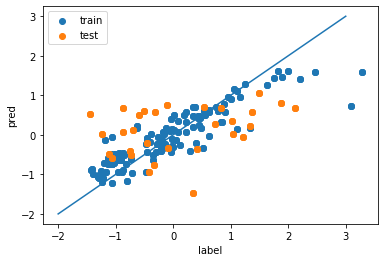

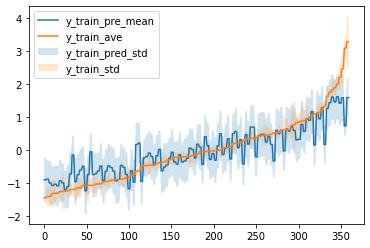

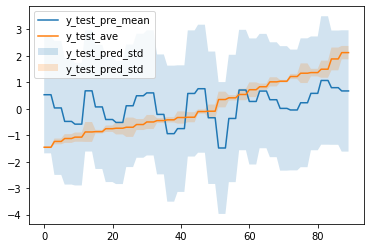

Train:  0.8307508531309108
Test:  0.07707772432964999


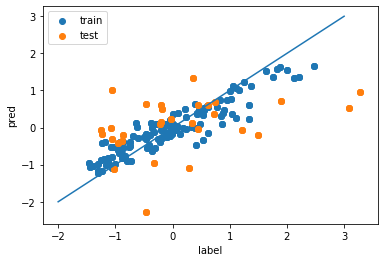

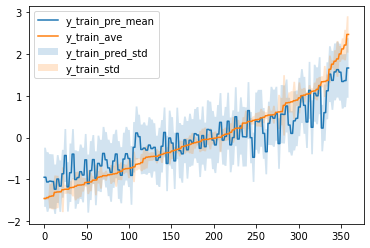

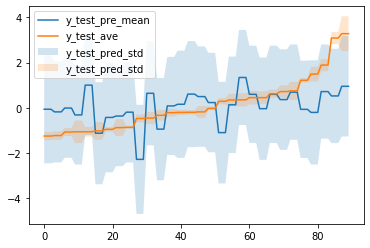

Train:  0.8182926075114215
Test:  -0.6988911631332908


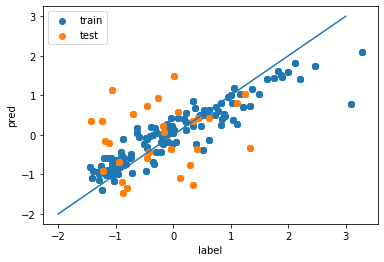

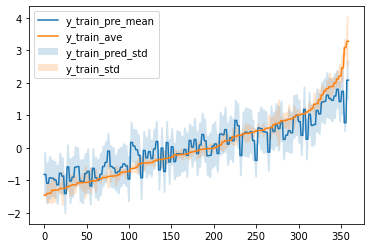

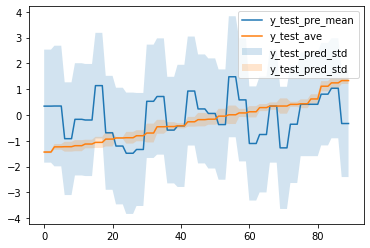

Train:  0.8365331704227741
Test:  -0.07906183775963727


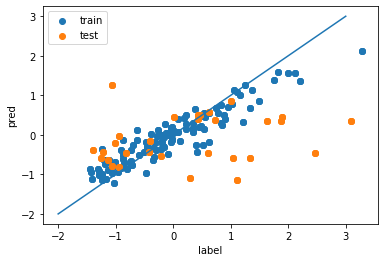

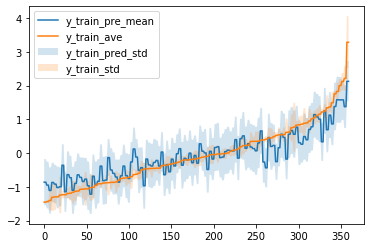

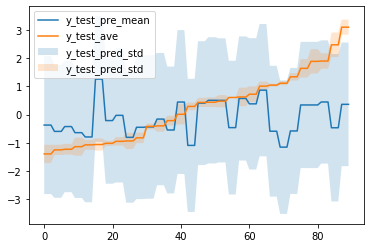

Train:  0.7734833382770674
Test:  -0.24673097510124187


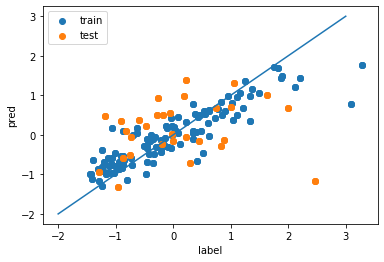

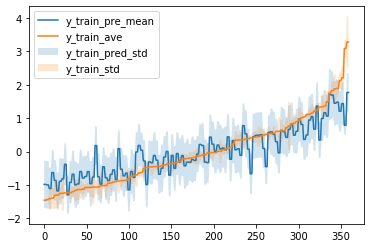

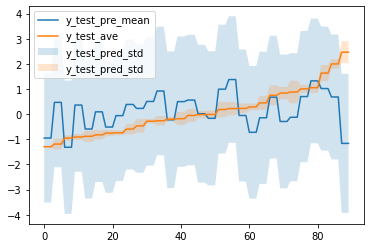

In [9]:
for i in range(10):
    regression(df, random_state=i, test_size=0.2, kernel_name='WD_Kernel',alpha=2, embedding='label',
                   eva_metric=r2_score, eva_on_ave_flag=True, l_list=[3], b=0.33, 
                   weight_flag=False, padding_flag=False, gap_flag=False)

Train:  0.47540498119147834
Test:  -0.09632338923904382


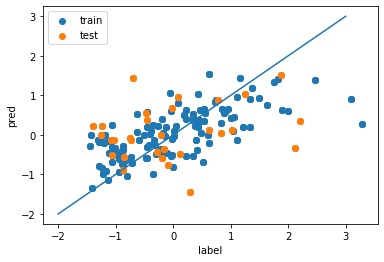

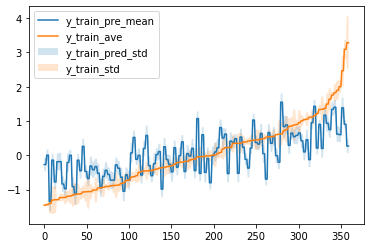

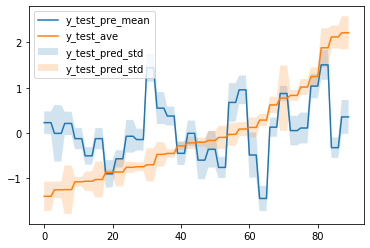

In [7]:
regression(df, random_state=24, test_size=0.2, kernel_name='Spectrum_Kernel',alpha=0.5, embedding='label',
               eva_metric=r2_score, eva_on_ave_flag=True, l_list=[3], b=0.33, 
               weight_flag=False, padding_flag=False, gap_flag=False)

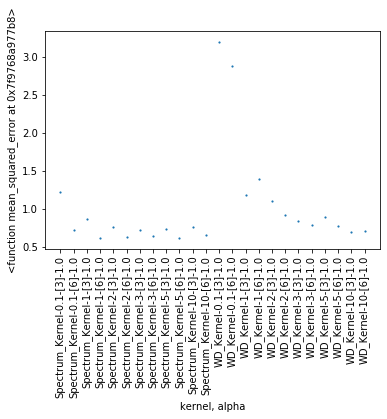

optimal kernel:  Spectrum_Kernel , optimal alpha:  5 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.364410234218403
Test:  0.8096347820952272


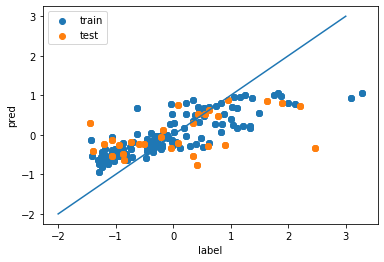

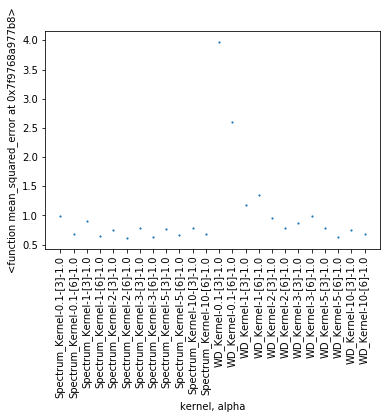

optimal kernel:  Spectrum_Kernel , optimal alpha:  2 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.20133077716905667
Test:  1.2672379977041859


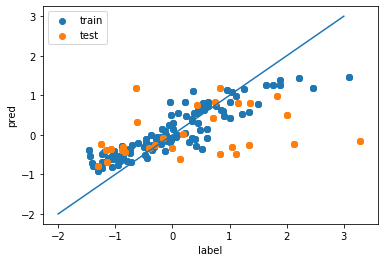

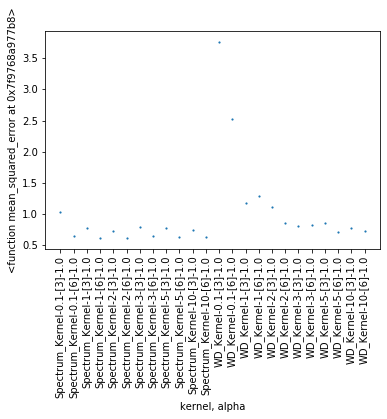

optimal kernel:  Spectrum_Kernel , optimal alpha:  2 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.2186357904347592
Test:  0.6912196403151323


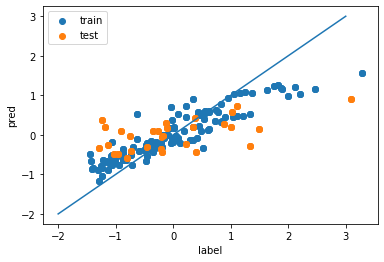

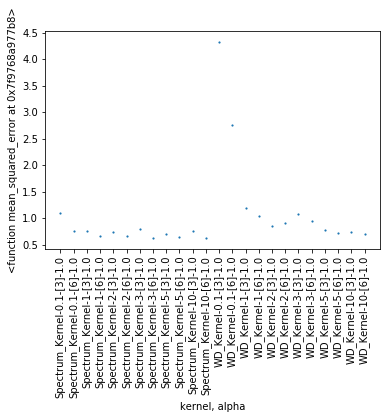

optimal kernel:  Spectrum_Kernel , optimal alpha:  3 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.31700002276689754
Test:  0.43375752844863397


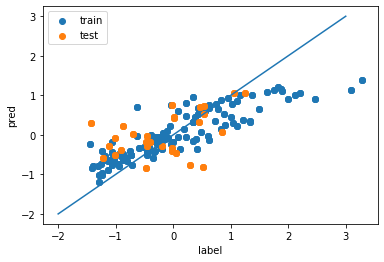

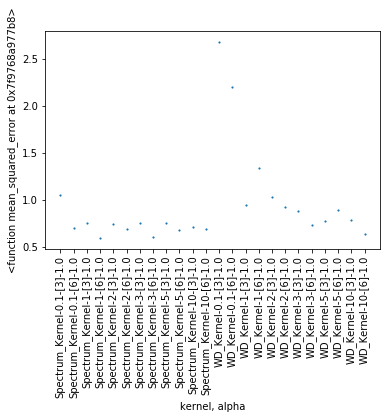

optimal kernel:  Spectrum_Kernel , optimal alpha:  1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.1313595220971409
Test:  0.61543134683845


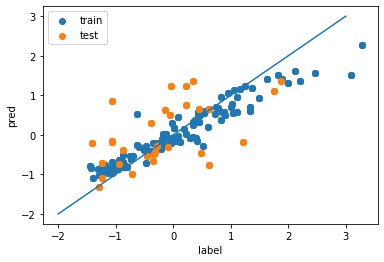

Cross-validation Test mean:  0.763456259080326
Cross-validation Test std:  0.2799140056780685


In [8]:
optimal_para, test_scores = cross_val(df, cv, random_state, test_size, kernel_list,  alpha_list, embedding, eva_metric, eva_on_ave_flag,
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

## Optimal Choices for splitting sequences case

- optimal kernel:  Spectrum_Kernel , 
- optimal alpha:  2 , 
- optiaml l list:  [2, 3, 4, 5, 6]

## Cross Validation for samples

In [9]:
Path = '../../data/firstRound_4h_normTrue_formatSample.csv'

df_samples = pd.read_csv(Path)
df_samples.head()

,Unnamed: 0,Name,RBS,RBS6,AVERAGE,STD,Group,variable,label
0,0,RBS_1by1_0,TTTAAGAAGGAGATATACAT,AGGAGA,3.089757,0.265769,reference,Rep2,2.783529
1,1,RBS_1by1_1,CTTAAGAAGGAGATATACAT,AGGAGA,1.880744,0.429851,bps_noncore,Rep2,1.678119
2,2,RBS_1by1_2,GTTAAGAAGGAGATATACAT,AGGAGA,0.352580,0.293404,bps_noncore,Rep2,0.670263
3,3,RBS_1by1_3,ATTAAGAAGGAGATATACAT,AGGAGA,1.634102,0.325173,bps_noncore,Rep2,1.948917
4,4,RBS_1by1_4,TCTAAGAAGGAGATATACAT,AGGAGA,1.892036,0.272748,bps_noncore,Rep2,2.201733


In [10]:
df_samples_frr = df_samples[df_samples['Group'] != 'Baseline data'].reindex()

In [11]:
df_samples_frr.shape

(450, 9)

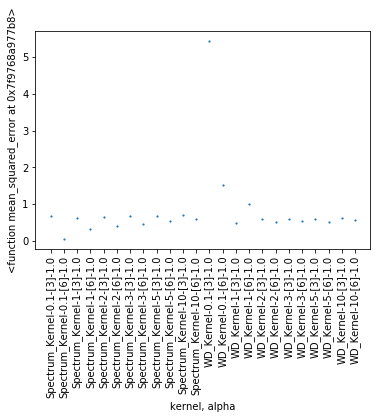

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.02214677505920513
Test:  0.09486414197304147


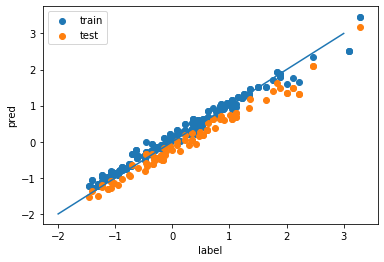

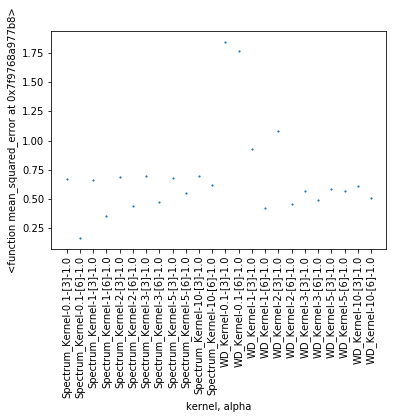

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.012976312978665258
Test:  0.0405428192334798


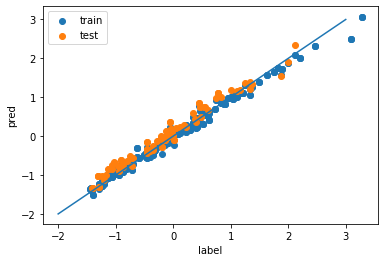

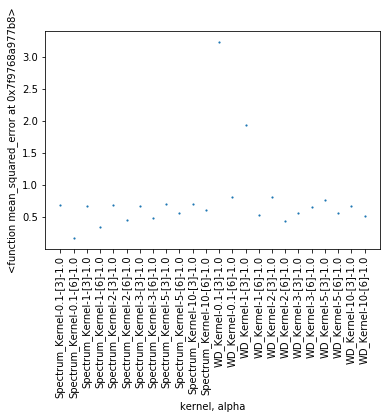

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.015248464148271952
Test:  0.05347310621852211


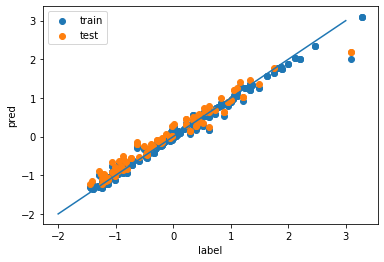

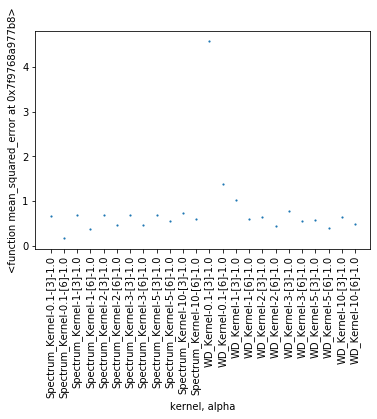

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.016486263708188367
Test:  0.13648518554828504


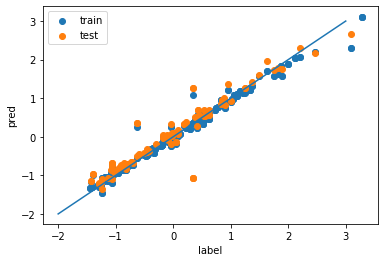

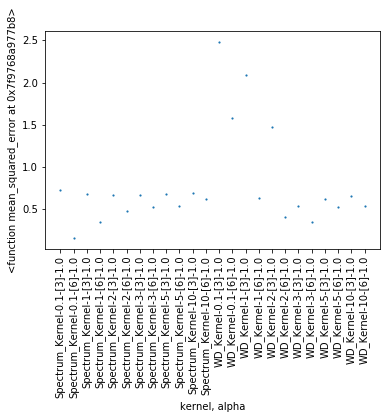

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.018469673753677408
Test:  0.06527918830575961


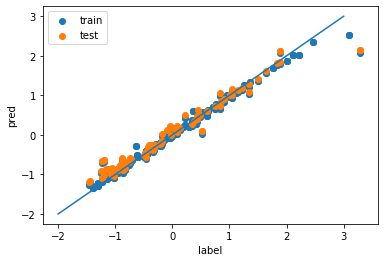

Cross-validation Test mean:  0.07812888825581761
Cross-validation Test std:  0.034267363808427924


In [12]:
optimal_para, test_scores = cross_val(df_samples, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag, 
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

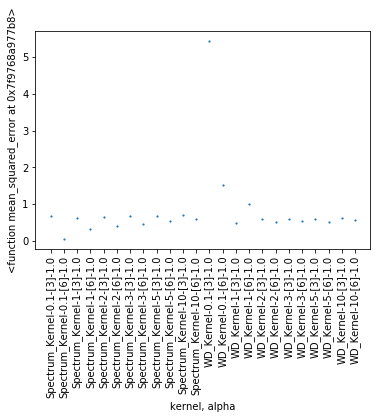

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.02214677505920513
Test:  0.09486414197304147


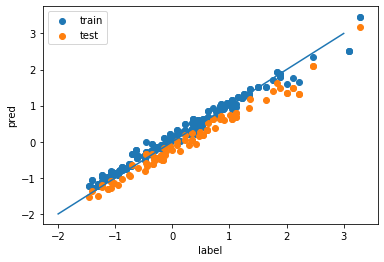

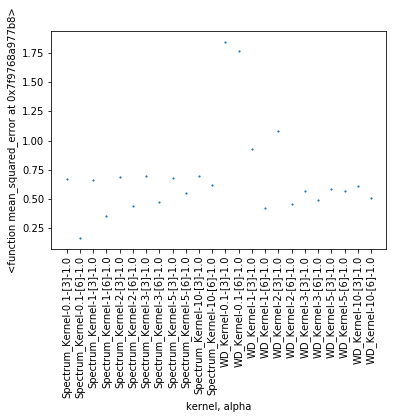

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.012976312978665258
Test:  0.0405428192334798


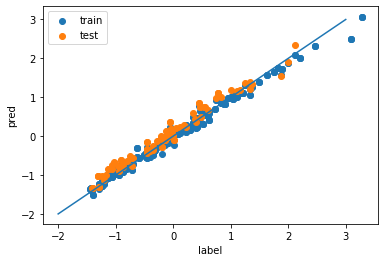

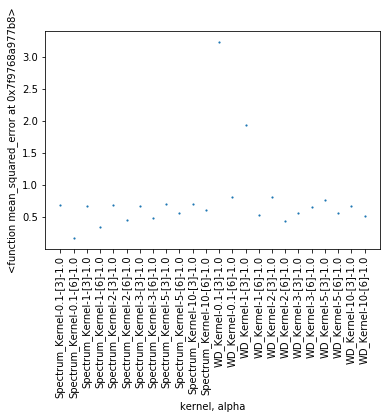

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.015248464148271952
Test:  0.05347310621852211


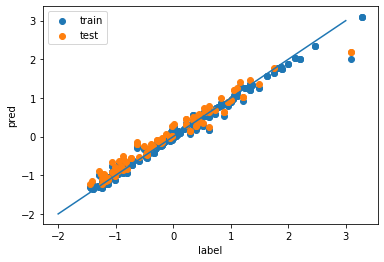

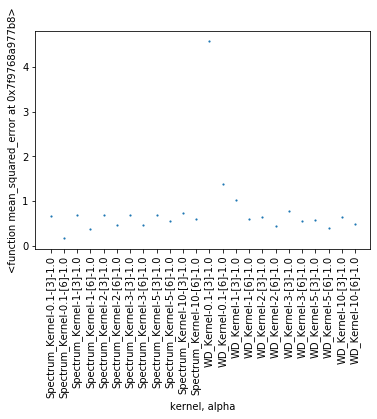

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.016486263708188367
Test:  0.13648518554828504


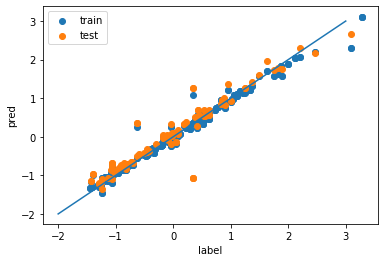

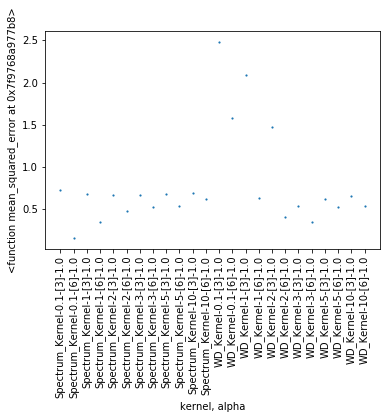

optimal kernel:  Spectrum_Kernel , optimal alpha:  0.1 , optiaml l list:  [6] , optimal b:  1.0
Spectrum_Kernel
1
Train:  0.018469673753677408
Test:  0.06527918830575961


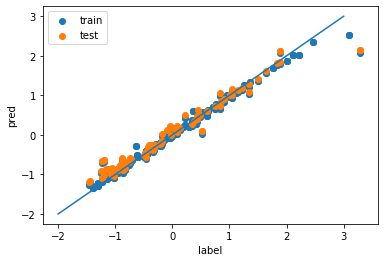

Cross-validation Test mean:  0.07812888825581761
Cross-validation Test std:  0.034267363808427924


In [13]:
optimal_para, test_scores = cross_val(df_samples_frr, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag, 
                                      l_lists, b_list, weight_flag, padding_flag, gap_flag)

## Optimal Choices for splitting samples case

- optimal kernel:  Spectrum_Kernel , 
- optimal alpha:  0.1 , 
- optiaml l list:  [2, 3, 4, 5, 6]
    
As we expected, when splitting in terms of samples, we have a smaller test error and smaller test error variance as well compared splitting in terms of sequences.

## Normalise replicates?

normalise each replicates to have same derivatives i.e. heteroscedastic noises are learned 

In [14]:
num_data = df.shape[0]
sorted_df = df.sort_values(['AVERAGE'])
plt.figure(figsize = (30,15))
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep1'], label = 'Rep1')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep2'], label = 'Rep2')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['Rep3'], label = 'Rep3')
ax = sns.scatterplot(sorted_df['RBS'], sorted_df['AVERAGE'], label = 'AVE')
labels = sorted_df['RBS']
ax.set_xticklabels(labels, rotation = 90)
plt.show()

# fit curve

from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

plt.figure(figsize = (20,10))

color_list = ['blue', 'orange', 'green', 'red']
popt_dict = {}

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ydata = np.asarray(sorted_df[rep].dropna())
    xdata = range(len(ydata))
    popt, pcov = curve_fit(func, xdata, ydata)
    print(popt)
    popt_dict[rep] = popt
    plt.plot(xdata, func(xdata, *popt), label = rep, color = color_list[i])
    plt.plot(xdata, ydata)
    plt.legend()

In [ ]:
df_normalised = sorted_df

for i, rep in enumerate(['Rep1', 'Rep2', 'Rep3', 'AVERAGE']):
    ratio = popt_dict[rep][0]/popt_dict['AVERAGE'][0]
    df_normalised[rep] = sorted_df[rep]/ratio
    normalised_rep = np.asarray(df_normalised[rep])
    
    xdata = range(len(normalised_rep))
    
    plt.plot(xdata, normalised_rep, label = rep, color = color_list[i])
    plt.legend()

In [ ]:
optimal_para, test_scores = cross_val(df_normalised, cv, random_state, test_size, kernel_list, alpha_list, embedding, eva_metric, eva_on_ave_flag,
                                     l_lists, b_list, weight_flag, padding_flag, gap_flag)

Unfortunately, from the test error mean and std, normalise replicates seem to have little effect on the perforamcne. 

## Summary

To summarise, for the second round design, we choose to use all first round results (NO baseline data), with 
- Spectrum kennel
- alpha = 2
- lmer, l = [2,3,4,5,6]
- with replicates normalisation
- Sample mean as true label
- normalised kernel
- (TODO) features: no gap, np padding, no weight?